# Sistema de comunicação 10G 4QAM/DQPSK (Differential Quadrature Phase-Shift Keying)

In [115]:
from commpy.modulation import Modem, QAMModem
from commpy.utilities  import signal_power, upsample, bitarray2dec, dec2bitarray
from commpy.filters    import rrcosfilter
from scipy.signal import lfilter
from sympy.combinatorics.graycode import GrayCode
from numpy.matlib import repmat
from numpy.random import randint

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import special as spec

from utils.dsp import pulseShape, firFilter
from utils.models import mzm

In [196]:
def filterNoDelay(h, x):
    """
    h: impulse response (symmetric)
    x: input signal 
    y: output signal
    """   
    N = h.size
    x = np.pad(x, (0, int(N/2)),'constant')
    y = lfilter(h,1,x)
    
    return y[int(N/2):y.size]

## Parâmetros de Simulação

In [175]:
M      = 16
SpS    = 32
Rs     = 10e9          # Taxa de símbolos
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
alpha  = 0.05          # Rolloff do filtro RRC
N      = 1024          # Número de coeficientes do filtro RRC
EbN0dB = 20

# Parâmetros do MZM:
Vπ = 2
Vb = -Vπ
Pi_dBm = -17  # potência de sinal óptico na entrada do modulador em dBm
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# Parâmetros do canal AWGN:
snrdB    = EbN0dB + 10*np.log10(np.log2(M))
noiseVar = 1/(10**(snrdB/10))
σ        = np.sqrt(noiseVar*SpS)
print(snrdB, noiseVar, σ)

26.020599913279625 0.002499999999999999 0.28284271247461895


## Transmissor

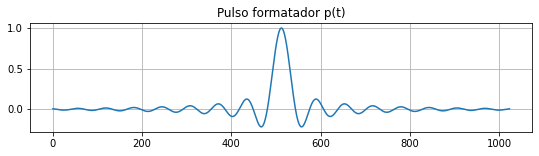

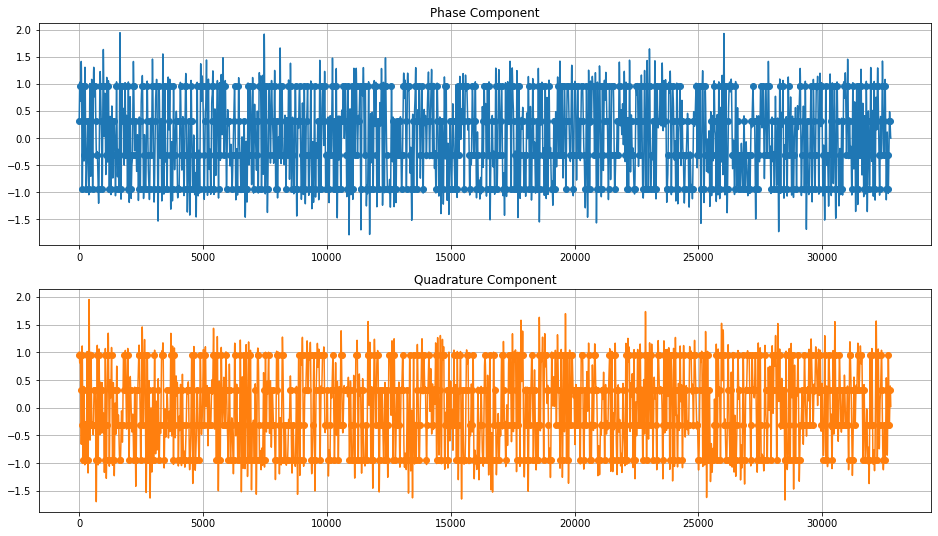

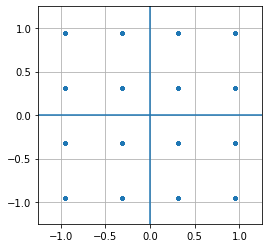

In [216]:
bitsTx = np.random.randint(2, size=2**12)
mod    = QAMModem(m=M)                             # Gera constelação M-QAM.
symbTx = mod.modulate(bitsTx)                      # Mapeia bits em Símbolos na constelação.
symbTx = symbTx/np.sqrt(mod.Es)                    # Normaliza energia dos símbolos.
symbUp = upsample(symbTx, SpS)                     # Upsample dos símbolos: símbolos -> Pulsos
pulse  = pulseShape('rrc', SpS, N, alpha, Ts)      # Pulso formatador p(t)
pulse  /= max(abs(pulse))
sigTxE = firFilter(pulse, symbUp)                  # Sinal elétrico formatado

# Plota Pulso:
fig = plt.figure(figsize=(9,2))
plt.plot(pulse)
plt.title("Pulso formatador p(t)")
plt.grid(True)

# Plota Componentes de fase e quadratura:
symbUp.real[symbUp.real==0] = np.nan
symbUp.imag[symbUp.imag==0] = np.nan
fig, axs = plt.subplots(2, figsize=(16,9))
axs[0].plot(sigTxE.real, "tab:blue")
axs[0].plot(symbUp.real, "o")
axs[0].grid(True)
axs[0].title.set_text("Phase Component")
axs[1].plot(sigTxE.imag, "tab:orange")
axs[1].plot(symbUp.imag, "o", color="tab:orange")
axs[1].grid(True)
axs[1].title.set_text("Quadrature Component")

# Plota constelação:
fig = plt.figure(figsize=(4,4))
plt.plot(symbTx.real, symbTx.imag, '.')
plt.xlim([-1.25, 1.25])
plt.ylim([-1.25, 1.25])
plt.grid(True)
plt.hlines(0, -1.25, 1.25)
plt.vlines(0, -1.25, 1.25)

(array([5.18053010e-25, 1.83441497e-24, 3.66206320e-24, ...,
        1.86300132e-24, 2.51679791e-24, 1.53373528e-24]),
 array([-1.60000000e+11, -1.59921875e+11, -1.59843750e+11, ...,
         1.59765625e+11,  1.59843750e+11,  1.59921875e+11]))

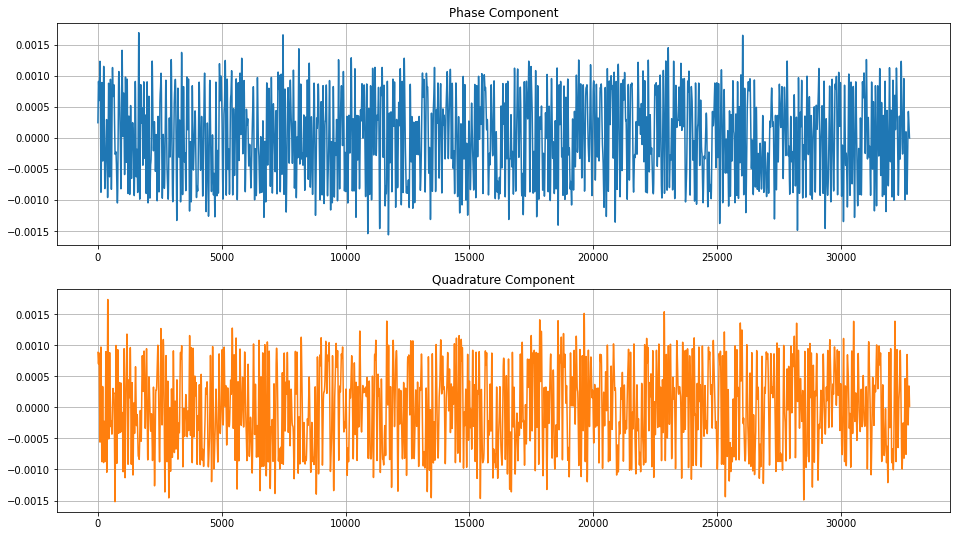

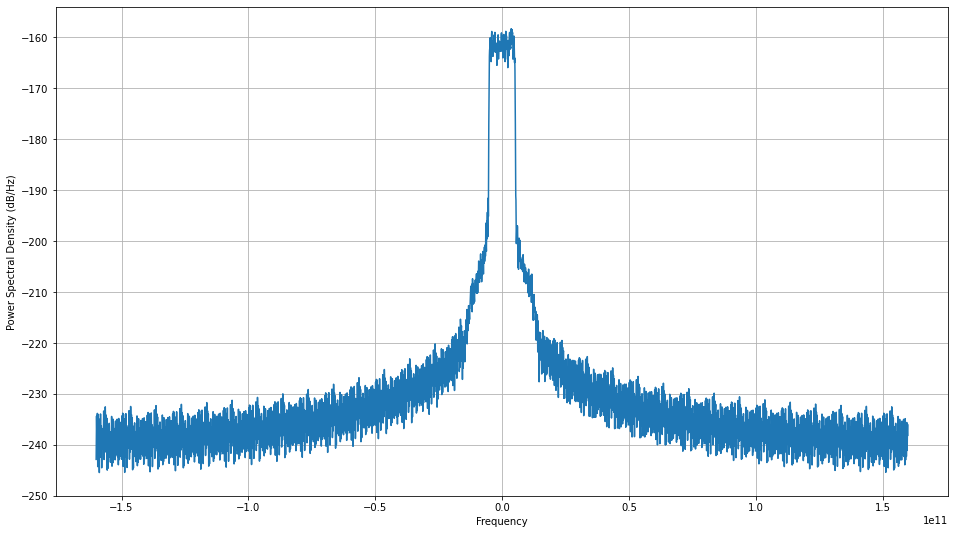

In [217]:
# Modulador de Mach-Zehnder:
Ai     = np.sqrt(Pi)
sigTxO = mzm(Ai, Vπ, 0.25*sigTxE, Vb)

# Plota sinal óptico:
fig, axs = plt.subplots(2, figsize=(16,9))
axs[0].plot(sigTxO.real, "tab:blue")
#axs[0].plot(symbUp.real, "o")
axs[0].grid(True)
axs[0].title.set_text("Phase Component")
axs[1].plot(sigTxO.imag, "tab:orange")
#axs[1].plot(symbUp.imag, "o", color="tab:orange")
axs[1].grid(True)
axs[1].title.set_text("Quadrature Component")

# Plota espectro:
fig = plt.figure(figsize=(16,9))
plt.psd(sigTxO,Fs=Fa, NFFT=4096, label = 'Espectro do Sinal Modulado')


## Canal Óptico 

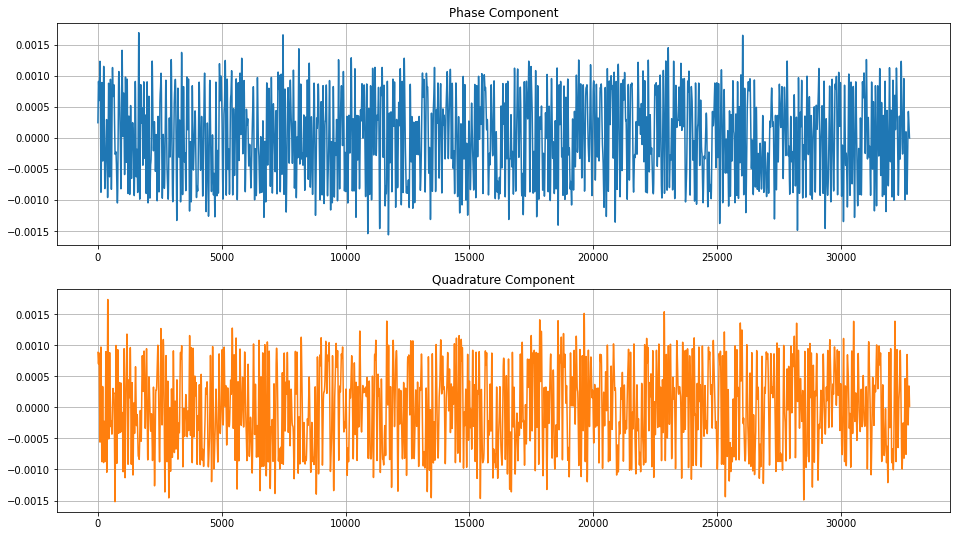

In [218]:
noise = (1e-5)*(np.random.normal(0,σ, sigTxO.size) + 1j*np.random.normal(0,σ, sigTxO.size))
noise = 1/np.sqrt(2)*noise    

sigTxORx = sigTxO #+ noise


# Plota Sinal + Ruído branco:
fig, axs = plt.subplots(2, figsize=(16,9))
axs[0].plot(sigTxORx.real, "tab:blue")
axs[0].grid(True)
axs[0].title.set_text("Phase Component")
axs[1].plot(sigTxORx.imag, "tab:orange")
axs[1].grid(True)
axs[1].title.set_text("Quadrature Component")


## Receptor

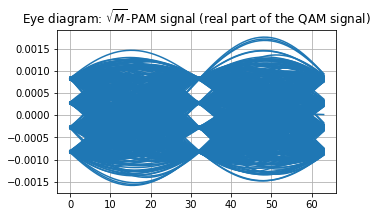

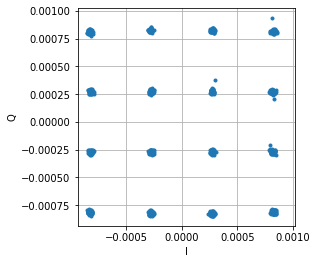

In [219]:
tindex, rrcFilter = rrcosfilter(N, alpha, Ts, Fa)
sigRx = filterNoDelay(rrcFilter, sigTxORx)    
sigRx = sigRx/SpS

symbRx = sigRx[0::SpS]                               # Subsampling

bitsRx = mod.demodulate(np.sqrt(mod.Es)*symbRx, demod_type = 'hard') # Demodula sinal recebido

# plota diagrama de olho:
plt.figure(3,figsize=(5,3));
plt.title('Eye diagram: $\sqrt{M}$-PAM signal (real part of the QAM signal)');
plt.plot(np.transpose(sigRx.real.reshape(int(sigRx.size/(2*SpS)),2*SpS)),color='tab:blue');
plt.grid()

# plota constelação recebida:
plt.figure()
plt.plot(symbRx.real,symbRx.imag,'.');
#plt.plot(symbTx.real,symbTx.imag,'.')
plt.xlabel('I');
plt.ylabel('Q');
plt.grid()
plt.axis('square');

In [220]:
discard = 200
numBits = bitsTx.size

ERR = np.logical_xor(bitsRx[discard:numBits-discard], bitsTx[discard:numBits-discard])
BER = ERR.sum()/ERR.size

print("BER: ", BER)

BER:  0.25595238095238093
